In [1]:
# set up autoreload
%reset
%load_ext autoreload
%autoreload 2

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
!pip install tensorflow_addons
!pip install loguru

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 1.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'Project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
print(sys.path)

Mounted at /content/drive
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/Project']


In [4]:
clip_name = 'Data_2023-10-24_10-28-15'#'Data_2023-11-06_09-47-30'
clip_path = r'/content/drive/My Drive/Project/Data_Test/' + clip_name + '.avi'
text_path = r'/content/drive/My Drive/Project/Data_Test/' + clip_name + '_merge.txt'
cp_path = r"/content/drive/MyDrive/Project/Checkpoints/cp.ckpt" #r"/content/drive/MyDrive/Project/Checkpoints/cp.ckpt.data-00000-of-00001"

In [5]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from script.dataset import DataManager, FrameDataGenerator

# check gpu
print(tf.sysconfig.get_build_info())
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices())

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


OrderedDict([('cpu_compiler', '/usr/lib/llvm-16/bin/clang'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '11.8'), ('cudnn_version', '8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', True)])
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
import cv2
from tqdm import tqdm

def get_frames(clip_path):

  frame_input, frame_output = None, None
  frames = None

  cap = cv2.VideoCapture(clip_path)
  length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  for _ in tqdm(range(length)):

    ret, frame = cap.read()

    if ret == True:
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

      if len(frame.shape)==2:
        frame = frame[:,:,np.newaxis]

      if not ret:
        return None,None

      if frames is None:
        frames = frame
      else:
        frames = np.concatenate((frames, frame),axis=2)

  frames = tf.image.convert_image_dtype(frames, dtype=tf.float32)
  frames = tf.image.resize(frames, (96, 128))

  frames = (frames-0.5)/0.1

  frame_input = frames[:,:,:]
  frame_output = (frames[:,:,-1])[:,:,tf.newaxis]

  return frame_input#, frame_output

100%|██████████| 4488/4488 [07:03<00:00, 10.59it/s]


(96, 128, 4488)


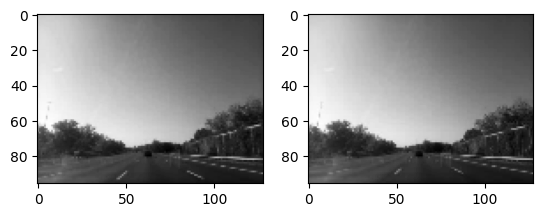

In [7]:
# Test get_frames function
import matplotlib.pyplot as plt

frame_in = get_frames(clip_path)

print(frame_in.shape)
plt.subplot(1,2,1)
plt.imshow(frame_in[:,:,1],'gray')
plt.subplot(1,2,2)
plt.imshow(frame_in[:,:,0],'gray')

In [8]:
def get_actions_file(text_path):

  action_data = None

  data = np.loadtxt(str(text_path))
  print(data)
  data = data/np.std(data, axis=0, keepdims=True)
  action_data = tf.convert_to_tensor(data, dtype=tf.float32)

  return action_data

# Test function
action_file = get_actions_file(text_path)
# print(action_file)


[[ 0.0000000e+00  4.3000000e-01  8.2300000e+00 ...  2.2000000e-03
   1.9600000e-02  8.0688190e+00]
 [-7.1000000e-01  9.0000000e-01  1.0130000e+01 ...  1.2000000e-02
   2.1800000e-02  6.1709976e+00]
 [ 1.1200000e+00  2.8000000e-01  8.2700000e+00 ... -7.6000000e-03
   2.4000000e-02  6.3089995e+00]
 ...
 [-1.7600000e+00 -3.7000000e-01  1.0900000e+01 ... -3.3000000e-03
  -5.5600000e-02  1.0775068e+01]
 [-1.1200000e+00 -1.7500000e+00  9.0800000e+00 ... -7.2000000e-02
  -4.2500000e-02  1.2209184e+01]
 [-1.2200000e+00 -1.1200000e+00  1.0470000e+01 ...  8.7000000e-03
  -4.3600000e-02  1.2068945e+01]]


In [9]:
def get_action(action_file, start_frame_no):

  # start_frame_no = 1
  length = action_file.shape[0]
  data = action_file[start_frame_no : start_frame_no + 10, :]
  data = tf.gather(data,axis=1,indices=[0,1,5,6])
  data = tf.math.reduce_mean(data,axis=0)

  return data

data_num = action_file.shape[0]
for i in tqdm(range(data_num)):
  act_data = get_action(action_file, i)



100%|██████████| 4488/4488 [00:03<00:00, 1166.67it/s]


In [10]:
from script.model import get_interaction_module, FramePredictionModel, custom_loss

config = {}
config["fold_n_frames"] = 10

action_dim = 4 # the txt files have 7 columns,but only 4 are used
nchan_ori=1 # convert to gray scale

img_h, img_w = 96,128

img_dim = (img_h,img_w,nchan_ori*config["fold_n_frames"])
encoder_output_dim = 2048

# set up models
layer_specs = [
                {"type":"input","kwargs":{"input_shape":img_dim}}, #0
                {"type":"conv2d","kwargs":{"filters": 128,  "kernel_size": 8, "strides":2,"activation":"relu"}}, #1
                {"type":"conv2d","kwargs":{"filters": 128, "kernel_size": 6, "strides":2,"activation":"relu"}}, #2
                {"type":"conv2d","kwargs":{"filters": 128, "kernel_size": 6, "strides":2,"activation":"relu"}}, #3
                {"type":"conv2d","kwargs":{"filters": 128, "kernel_size": 4, "strides":2,"activation":"relu"}}, #4
                {"type":"flatten"}, #5
                {"type":"dense","kwargs":{"units":encoder_output_dim,"activation":"relu"}} #6
            ]
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=img_dim),
    tf.keras.layers.Conv2D(**layer_specs[1]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(**layer_specs[2]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(**layer_specs[3]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(**layer_specs[4]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(encoder_output_dim, activation='relu')
])

# define interaction module
interaction_dim, interaction_output_dim = 2048, 2048
interaction = get_interaction_module(encoder_dim=encoder_output_dim, action_dim=action_dim, intermediate_dim=interaction_dim, output_dim=interaction_output_dim)

# interaction = tf.keras.Sequential(
#     [
#         tf.keras.layers.Dense(units=2048,activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(units=2048,activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(units=interaction_output_dim,activation='relu'),
#     ]
# )

# define decoder
# get the output size of the last conv layer
conv_out_size = encoder.layers[6].output_shape[1:]
nchan = 128
fc_dim = int(np.prod(conv_out_size[:2])*nchan)
layer_specs = [
                {"type":"input_shape","kwargs":{"shape":(interaction_output_dim,)}}, #0
                {"type":"dense","kwargs":{"units":fc_dim,"activation":"relu"}}, #1
                {"type":"reshape","kwargs":{"target_shape":(conv_out_size[0],conv_out_size[1],nchan)}}, #2
                {"type":"conv2dtr","kwargs":{"filters": 128, "kernel_size": 4, "strides":2,"activation":"relu"}}, #3
                {"type":"conv2dtr","kwargs":{"filters": 128, "kernel_size": 6, "strides":2,"activation":"relu"}}, #4
                {"type":"conv2dtr","kwargs":{"filters": 128, "kernel_size": 6, "strides":2,"activation":"relu", "output_padding":1}}, #5
                {"type":"conv2dtr","kwargs":{"filters": nchan_ori, "kernel_size": 8, "strides":2,"activation":None}}, #6
                ]

decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(interaction_output_dim,)),
    tf.keras.layers.Dense(units=fc_dim,activation='relu'),
    tf.keras.layers.Reshape(target_shape=(conv_out_size[0],conv_out_size[1],nchan)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(**layer_specs[3]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(**layer_specs[4]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(**layer_specs[5]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(**layer_specs[6]["kwargs"]),
])

# print('output shape of decoder: ', decoder.output_shape)
# make sure decoder output matches the input image's size
assert(decoder.output_shape[1:3]==img_dim[:2])
assert(decoder.output_shape[-1]==nchan_ori)

# get full model
fpm = FramePredictionModel(img_dim, action_dim, encoder,interaction, decoder)
fpm.load_weights(cp_path)
fpm.build(input_shape=[(None, *img_dim),(None,action_dim)])
fpm.summary()

Model: "frame_prediction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2048)              5460480   
                                                                 
 sequential_4 (Sequential)   (None, 96, 128, 1)        5385985   
                                                                 
 model (Functional)          (None, 2048)              11362816  
                                                                 
Total params: 22209281 (84.72 MB)
Trainable params: 22200321 (84.69 MB)
Non-trainable params: 8960 (35.00 KB)
_________________________________________________________________


100%|██████████| 4468/4468 [08:24<00:00,  8.85it/s]


Text(0, 0.5, 'mse score')

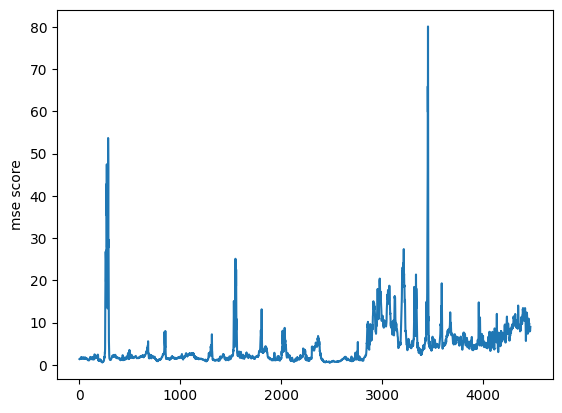

In [11]:
from sklearn.metrics import r2_score, mean_squared_error


r2_scores = []
mse_scores = []
pred_frames = None
gt_frames = None

for i in tqdm(range(data_num-20)):

  # Not predecting last frame
  # if (frame_in.shape[2] == data_num-1):
  #   break

  current_frames = frame_in[:,:,i:i+10]
  frame_gt = frame_in[:, :, i+11]

  act_data = get_action(action_file, i)

  frames_expanded = tf.expand_dims(current_frames, axis=0)
  act_expened = tf.expand_dims(act_data, axis=0)

  # frame_out_pred = fpm([current_frames[tf.newaxis,:], act_data[tf.newaxis,:]], training=False)
  frame_out_pred = fpm((frames_expanded, act_expened), training=False)

  if pred_frames is None:
    pred_frames, gt_frames = frame_out_pred, frame_gt[:,:,np.newaxis]
  else:
    pred_frames = np.concatenate((pred_frames, frame_out_pred),axis=0)
    gt_frames = np.concatenate((gt_frames, frame_gt[:,:,np.newaxis]), axis=2)

  r2 = r2_score(frame_gt.numpy().flatten(), frame_out_pred[0].numpy().flatten())
  r2_scores.append(r2)

  mse = mean_squared_error(frame_gt.numpy().flatten(), frame_out_pred[0].numpy().flatten())
  mse_scores.append(mse)



plt.plot(mse_scores)
plt.ylabel("mse score")



Text(0, 0.5, 'r2 score')

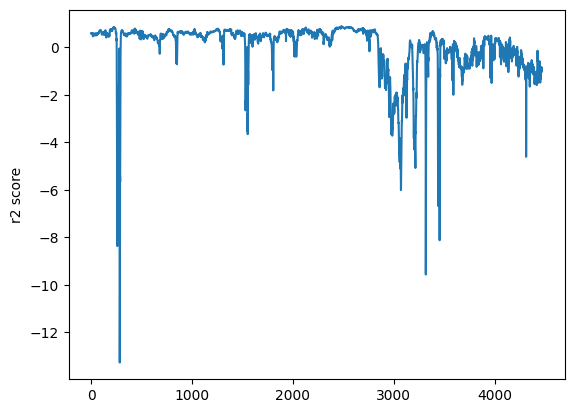

In [12]:
plt.plot(r2_scores)
plt.ylabel("r2 score")


MSE: 2.285866

R2 Score: 0.460056



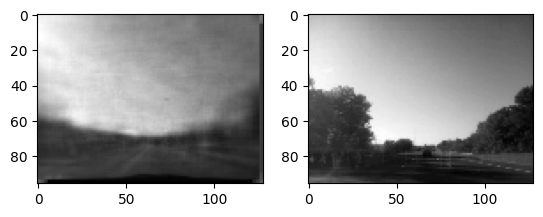

In [14]:
print('\nMSE: %f' %(np.median(mse_scores)))
print('\nR2 Score: %f' %(np.median(r2_scores)))
print()

plt.subplot(1,2,1)
plt.imshow(pred_frames[500],'gray')
plt.subplot(1,2,2)
plt.imshow(frame_in[:, :, 500],'gray')

In [15]:
# Save video
save_path = r'/content/drive/My Drive/Project/'

frame_size = (128*2, 96)

frames_save = ((pred_frames-(-10))/20)
frames_save = np.clip(frames_save, 0, 1)
frames_save = (frames_save*255.0).astype(np.uint8)

gt_frames_save = ((gt_frames-(-10))/20)
gt_frames_save = np.clip(gt_frames_save, 0, 1)
gt_frames_save = (gt_frames_save*255.0).astype(np.uint8)

save_clip = cv2.VideoWriter(save_path + clip_name + '_pred.avi',  cv2.VideoWriter_fourcc('M','J','P','G'), 15, frame_size)

for i in tqdm(range(frames_save.shape[0])):
  # print(frames_save[i].reshape(96,128).shape)
  # print(gt_frames_save[:,:,i])
  frame_combine = np.hstack((gt_frames_save[:,:,i], frames_save[i].reshape(96,128)))
  # print(frame_combine.shape)
  save_clip.write(cv2.cvtColor(frame_combine, cv2.COLOR_GRAY2BGR))

save_clip.release()

100%|██████████| 4468/4468 [00:03<00:00, 1257.03it/s]
